![](resource/ECG-waves.jpg)

sumber : [link](https://litfl.com/qt-interval-ecg-library/)

original source :
[marianpetruk/ECG_analysis](https://github.com/marianpetruk/ECG_analysis)

In [258]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os 

In [273]:
folder_dataset = "dataset/"
# read dataset, skip first row
ECG = pd.read_csv(os.path.join(folder_dataset, "CUDB 01.csv"), skiprows = [0])

ECG.columns = ['Time', 'ECG']

ECG.head()

,Time,ECG
0,'0:00.000',-0.273
1,'0:00.004',-0.307
2,'0:00.008',-0.297
3,'0:00.012',-0.320
4,'0:00.016',-0.333


In [274]:
# replace not required char in Time_norm Series 
ECG["Time_norm"] = ECG.Time.apply(lambda x:  "00:0" + x.replace("[", "") \
                                                      .replace("]", "") \
                                                      .replace("'", "") \
                                                      .replace("'",""))

# create Series with dtype Time
ECG["Idx_Time"] = pd.to_datetime(ECG["Time_norm"], errors='coerce', format="%H:%M:%S.%f")

#Set Time as Index
ECG.index = ECG["Idx_Time"]

# Calc sampling rate
fs = len(ECG['1900-01-01 00:00:00'])

# delete unused column 
ECG.drop('Idx_Time', axis=1, inplace=True)
ECG.drop('Time_norm', axis=1, inplace=True)
ECG.drop('Time', axis=1, inplace=True)

In [275]:
def plot_signal(data, fs, label="ECG sample raw data"):
    plt.figure(figsize=(20, 5))
    plt.ylabel("Amplitude")

    # Calculate time values in seconds
    times = np.arange(data.shape[0], dtype='float') / fs

    plt.plot(times, data)
    plt.xlabel("Time (s)")
    plt.title(label)
    plt.grid(True)
    plt.show()

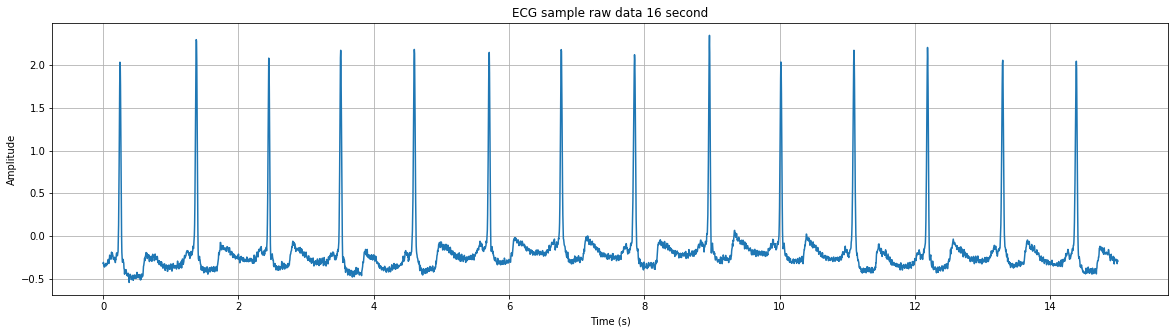

In [317]:
plot_signal(ECG.between_time('00:00:16','00:00:31'), fs, "ECG sample raw data 16 second")

### Normalization

In [336]:
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta, datetime

In [337]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
        
time_interval = [time_result for time_result in perdelta(ECG.index.min(), ECG.index.max(), timedelta(seconds=16))]

In [339]:
scaler = MinMaxScaler()
scaler = scaler.fit(ECG)
ECG_Norm = []
for time_intv in list(zip(time_interval, time_interval[1:])):
    X = ECG.between_time(time_intv[0].time(), time_intv[1].time())
    X_norm = scaler.transform(X) 
    ECG_Norm.append(X_norm)

In [340]:
ECG_Norm[0].shape

(4001, 1)

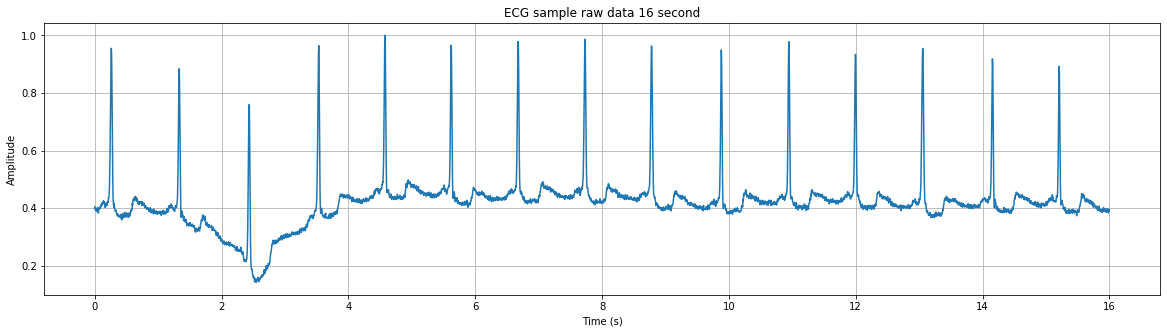

In [341]:
plot_signal(ECG_Norm[0], fs, "ECG sample raw data 16 second")

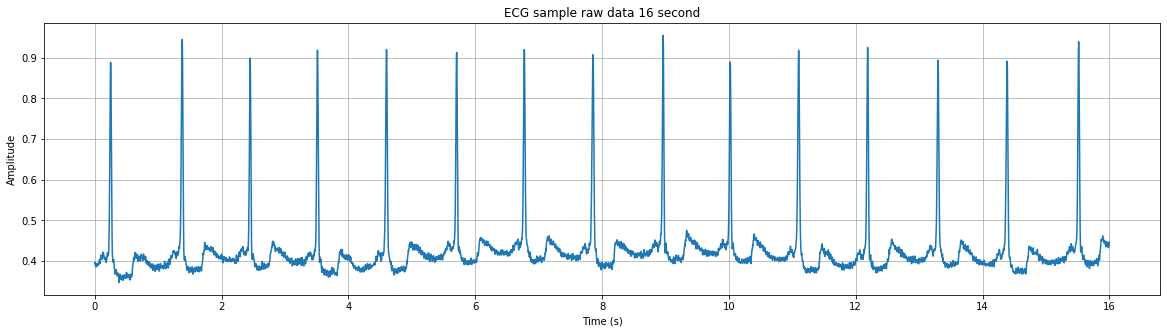

In [342]:
plot_signal(ECG_Norm[1], fs, "ECG sample raw data 16 second")

___
___
___
## QRS Detection

pip package : `pip install py-ecg-detectors`

In [352]:
from ecgdetectors import Detectors

detectors = Detectors(fs)

In [353]:
def plot_r_peaks(r_peaks, data, fs, label = "Detected R peaks"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_peaks], ymin, ymax,
               color="r",
               linewidth=2)

    plt.title(label)
    plt.grid(True)
    plt.show()

**Christov**

Implementation of Ivaylo I. Christov, “Real time electrocardiogram QRS detection using combined adaptive threshold”, BioMedical Engineering OnLine 2004, vol. 3:28, 2004

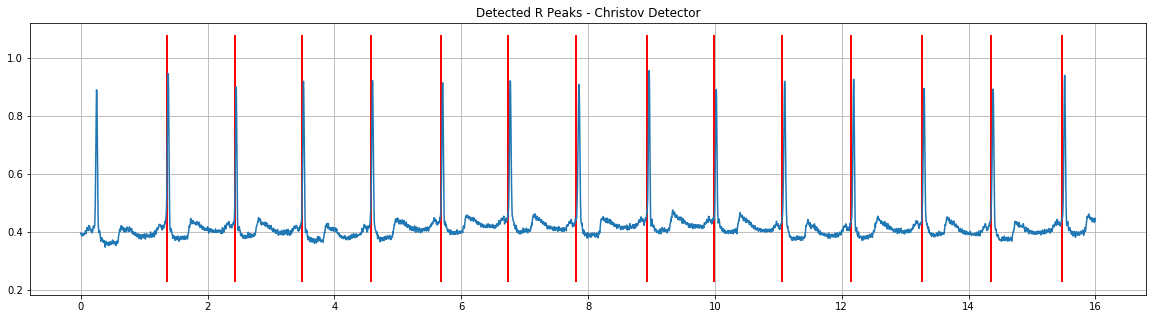

In [360]:
data = np.array(ECG_Norm[1])

r_peaks = detectors.christov_detector(data)

plot_r_peaks(r_peaks, data, fs, label="Detected R Peaks - Christov Detector")

**Engelse and Zeelenberg**

Implementation of W. Engelse and C. Zeelenberg, “A single scan algorithm for QRS detection and feature extraction”, IEEE Comp. in Cardiology, vol. 6, pp. 37-42, 1979 with modifications A. Lourenco, H. Silva, P. Leite, R. Lourenco and A. Fred, “Real Time Electrocardiogram Segmentation for Finger Based ECG Biometrics”, BIOSIGNALS 2012, pp. 49-54, 2012.

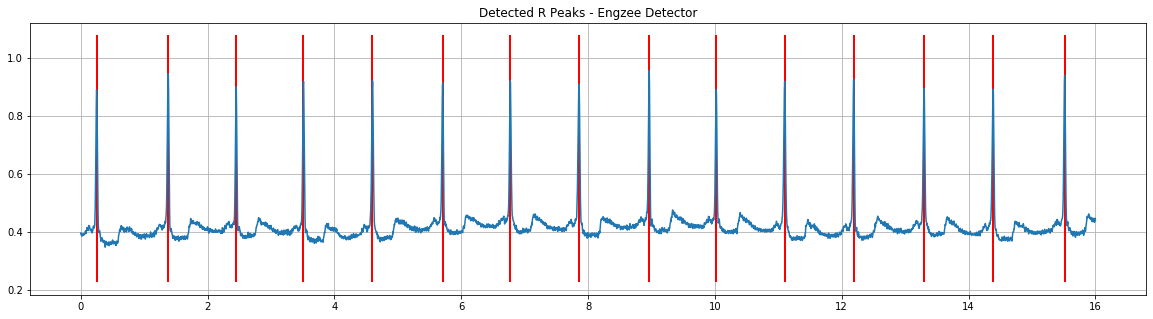

In [361]:
data = np.array(ECG_Norm[1])

r_peaks = detectors.engzee_detector(data)

plot_r_peaks(r_peaks, data, fs, label="Detected R Peaks - Engzee Detector")

### RR-intervals (aka NN-intervals)

The term **`NN`** is used in place of **RR** to emphasize the fact that the processed beats are "normal" beats. (с) Wikipedia

Heart rate variability (HRV) is the physiological phenomenon of variation in the time interval between heartbeats. It is measured by the variation in the beat-to-beat interval.

In [362]:
rr = np.diff(r_peaks) / fs * 1000  # in miliseconds

print("rr interval =", rr)

rr interval = [1128. 1072. 1064. 1088. 1108. 1064. 1084. 1108. 1056. 1080. 1088. 1112.
 1088. 1128.]


### Heartrate variability analysis


In [363]:
from hrv import HRV

hrv = HRV(fs)

r_peaks = np.array(r_peaks)

print("HR \n", hrv.HR(r_peaks))
# print("\nNN20 \n", hrv.NN20(r_peaks))
# print("\nNN50 \n", hrv.NN20(r_peaks))
# print("\nSRMSSD \n", hrv.RMSSD(r_peaks))
# print("\nSDANN \n", hrv.SDANN(r_peaks))
# print("\nSDNN \n", hrv.SDNN(r_peaks))
# print("\nSDSD \n", hrv.SDSD(r_peaks))
# print("\nfAnalysis \n", hrv.fAnalysis(r_peaks))
# print("\npNN20 \n", hrv.pNN20(r_peaks))
# print("\npNN50 \n", hrv.pNN50(r_peaks))

HR 
 [53.19148936 55.97014925 56.39097744 55.14705882 54.15162455 56.39097744
 55.35055351 54.15162455 56.81818182 55.55555556 55.14705882 53.95683453
 55.14705882 53.19148936]


## Splitting QRS

## Denoising using Adaptive Filtering

In [343]:
def add_AWGN_noise(signal, target_snr_db):
    
    # Calculate signal and convert to dB 
    sig_avg = np.mean(signal)
    sig_avg_db = 10 * np.log10(sig_avg)
    
    # Calculate noise : 
    # SNR_db = Signal_db - Noise_db
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    
    # Generate an sample of white noise
    mean_noise = 0
    sigma = np.sqrt(noise_avg_watts)
    noise = np.random.normal(mean_noise, sigma, len(signal))

    return (signal+noise)

In [350]:
def plot_noised_signal(signals, target_snr_db):
    
    plt.figure(figsize=(15,15))    
    
    num_class = signals.shape[1]
    noise_signals = []
    j = 1

    # Calculate time values in seconds
    times = np.arange(signals.shape[0], dtype='float') / fs
    
    for i in range(num_class): 

        # add AWGN noise
        noised_signal=add_AWGN_noise(signals[:, i], target_snr_db)
        noise_signals.append(noised_signal)
        
        plt.subplot(num_class,2,j)
        plt.plot(times, signals[:, i], label="class " + str(i))
        plt.title("original")
        plt.legend()

        plt.subplot(num_class,2,j+1)
        plt.plot(times, noised_signal, label="class " + str(i))
        plt.title("Noised with AWGN")
        plt.legend()
        
        j=j+2
    
    plt.tight_layout()
    plt.show()
    
    return np.array(noise_signals)

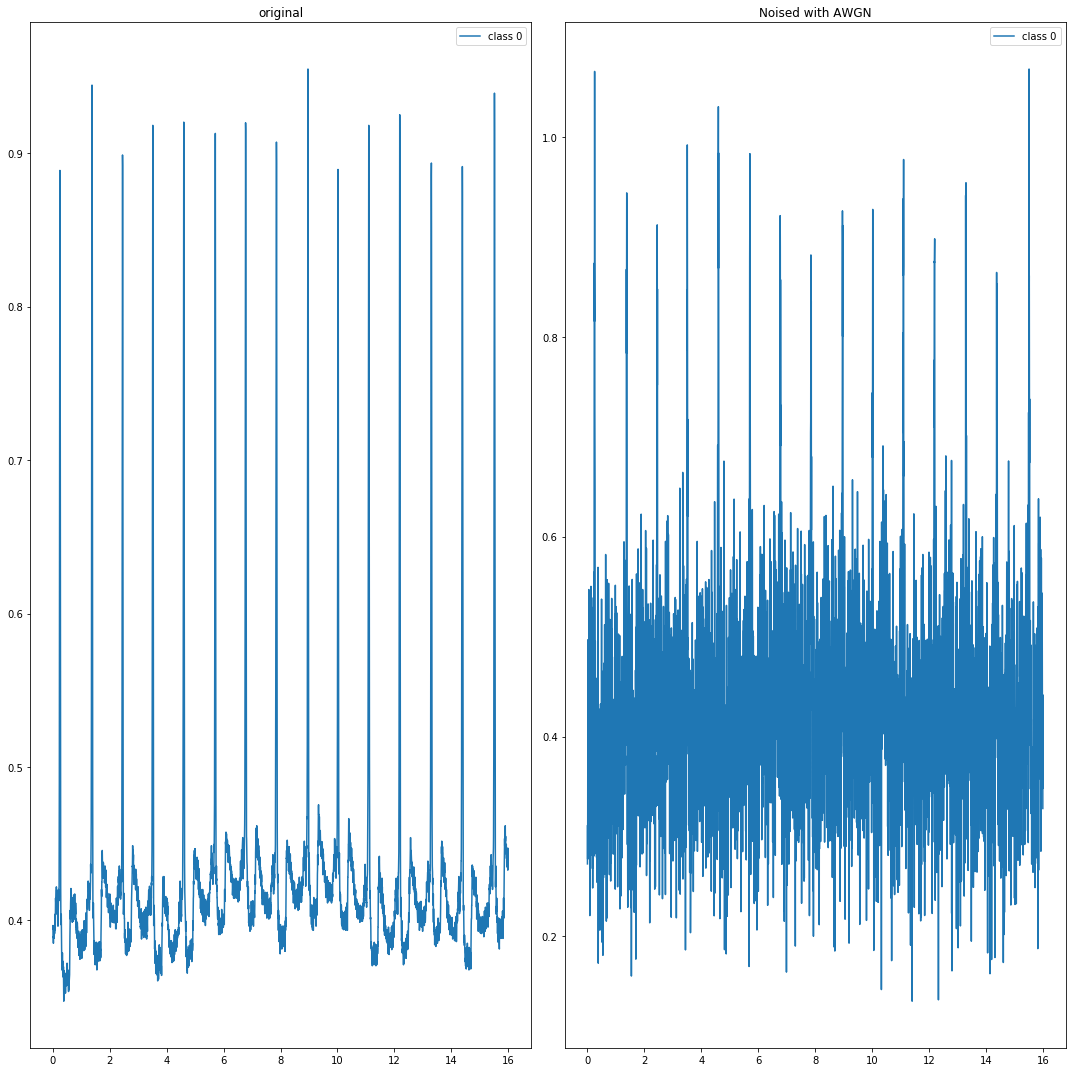

In [351]:
signals = ECG_Norm[1]

noise_signal_list = plot_noised_signal(signals, target_snr_db=18)

In [323]:

add_AWGN_noise(signals, 18)

C:\Users\yunus\Anaconda3\envs\ROOT\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [325]:
signals

array([[-0.13617021],
       [-0.13191489],
       [-0.14765957],
       ...,
       [-0.02978723],
       [-0.04893617],
       [-0.04680851]])